# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [1]:
# !pip install cartopy xarray matplotlib netCDF4 torch

In [2]:
import helper_functions
import importlib
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

## Data Loading & Preprocessing

In [3]:
def preprocessing(ds, features: list, depths: list):
    def standardize(group):
        m = group.mean("time")
        s = group.std("time")
        return (group - m) / s

    channels = []
    masks = []

    for feature in features:
        for depth in depths:
            try:
                data = ds[feature].sel(depth=depth, method="nearest")
                data = data.assign_coords(month=data["time"].dt.month)
                z = data.groupby("month").apply(standardize)
                z = z.transpose("time", "latitude", "longitude")

                mask = (~np.isnan(z)).astype(np.float32)
                z_filled = z.fillna(0.0)

                channels.append(z_filled)
                masks.append(mask)

            except Exception as e:
                print(f"⚠️ Skipping {feature}@{depth}m: {e}")
                continue

    z_all = xr.concat(channels, dim="channel").transpose("time", "channel", "latitude", "longitude")
    m_all = xr.concat(masks, dim="channel").transpose("time", "channel", "latitude", "longitude")

    return z_all.values.astype(np.float32), m_all.values.astype(np.float32)


In [4]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")

# X = preprocessing(ds, ["thetao", "so"], [50, 300, 1000])
# X_tensor = torch.tensor(X, dtype=torch.float32)
# print(X.shape)

# # input_dimension = X.shape[1]
# # print(z_temp.nbytes / 1e6, "MB")

## Splitting

In [5]:
X_np, M_np = preprocessing(ds, ["thetao", "so"], [50, 300, 1000])
X = torch.tensor(X_np)  # (B, C, H, W)
M = torch.tensor(M_np)

In [6]:
from torch.utils.data import Dataset

class MaskedDataset(Dataset):
    def __init__(self, X, M):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.M = torch.tensor(M, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.M[idx]


In [7]:
# X = X.astype(np.float32)
# X_train, X_test = train_test_split(X, test_size=0.1, random_state=27)

# train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=32, shuffle=True)
# test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=32, shuffle=False)

## The Architecture

In [8]:
class CAE(nn.Module):
    def __init__(self, in_channels, latent_dim=64):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2, padding=1),  # 203×514 → ~102×257
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),           # → ~51×129
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),          # → ~26×65
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 128×26×65 = 216320
        self.unflatten_shape = (128, 26, 65)
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(128 * 26 * 65, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, 128 * 26 * 65)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # → ~52×130
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),   # → ~104×260
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, in_channels, 3, stride=2, padding=1, output_padding=1),  # → ~208×520
        )

    def forward(self, x):
        x = self.encoder(x)
        z = self.fc_enc(self.flatten(x))
        x = self.fc_dec(z)
        x = x.view(x.size(0), *self.unflatten_shape)
        x = self.decoder(x)
        return x[:, :, :203, :514]  # ✨ zuschneiden auf Originalgröße



In [9]:
model = CAE(in_channels=X.shape[1])
output = model(X)[:, :, :203, :514]

loss = ((output - X)**2 * M).sum() / M.sum()

In [10]:
train_losses = []
val_losses = []

## Training Loop

In [11]:
def train(num_epochs: int):
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for x, mask in train_loader:
            x = x.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()
            x_recon = model(x)
            loss = masked_mse(x_recon, x, mask)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x, mask in test_loader:
                x = x.to(device)
                mask = mask.to(device)
                x_recon = model(x)
                loss = masked_mse(x_recon, x, mask)
                running_val_loss += loss.item() * x.size(0)

        val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


## Loss & Setup

In [12]:
def masked_mse(x_recon, x_true, mask):
    loss = ((x_recon - x_true) ** 2) * mask
    return loss.sum() / mask.sum()

In [59]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Annahme: du hast schon X_np, M_np aus preprocessing()
from torch.utils.data import DataLoader, random_split

full_dataset = MaskedDataset(X_np, M_np)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(val_set, batch_size=8)

model = CAE(in_channels=X_np.shape[1], latent_dim=9).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [60]:
num_epochs = 15
train_losses, val_losses = train(num_epochs)

Epoch 1/15 | Train Loss: 0.9722 | Val Loss: 0.8916
Epoch 2/15 | Train Loss: 0.8827 | Val Loss: 0.8389
Epoch 3/15 | Train Loss: 0.8578 | Val Loss: 0.8463
Epoch 4/15 | Train Loss: 0.7935 | Val Loss: 0.7648
Epoch 5/15 | Train Loss: 0.7654 | Val Loss: 0.7361
Epoch 6/15 | Train Loss: 0.7197 | Val Loss: 0.7141
Epoch 7/15 | Train Loss: 0.6832 | Val Loss: 0.6863
Epoch 8/15 | Train Loss: 0.6513 | Val Loss: 0.6508
Epoch 9/15 | Train Loss: 0.6125 | Val Loss: 0.6213
Epoch 10/15 | Train Loss: 0.5852 | Val Loss: 0.5993
Epoch 11/15 | Train Loss: 0.5607 | Val Loss: 0.5895
Epoch 12/15 | Train Loss: 0.5450 | Val Loss: 0.5804
Epoch 13/15 | Train Loss: 0.5309 | Val Loss: 0.5659
Epoch 14/15 | Train Loss: 0.5152 | Val Loss: 0.5531
Epoch 15/15 | Train Loss: 0.4939 | Val Loss: 0.5531


## Evaluation

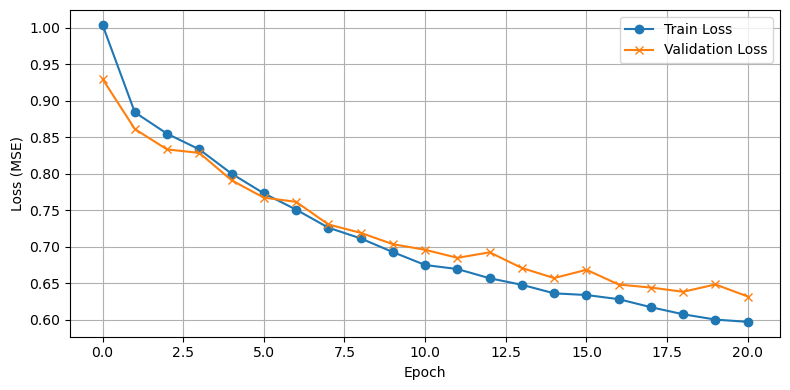

In [57]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Rconstructing

In [51]:
def plot_reconstruction_comparison(z_stack_original: xr.DataArray, 
                                   z_stack_recon: xr.DataArray, 
                                   time_indices: list, 
                                   cmin=None, 
                                   cmax=None):
    """
    Vergleicht Original- und Rekonstruktionskarten nebeneinander.

    Args:
        z_stack_original: xr.DataArray (time, location), z.B. aus preprocessing.
        z_stack_recon: xr.DataArray mit gleichem Aufbau, z.B. nach CAE-Rekonstruktion.
        time_indices: Liste von Zeitindizes (ints), die dargestellt werden sollen.
        cmin, cmax: (optional) Farbbereich der Colorbar.
    """

    # (time, location) → (time, lat, lon)
    z_unstacked_orig = z_stack_original.unstack("location")
    z_unstacked_recon = z_stack_recon.unstack("location")

    # Gemeinsame Farbrange
    vmin = cmin if cmin is not None else min(z_unstacked_orig.min().item(), z_unstacked_recon.min().item())
    vmax = cmax if cmax is not None else max(z_unstacked_orig.max().item(), z_unstacked_recon.max().item())

    n = len(time_indices)
    fig, axes = plt.subplots(n, 2, figsize=(6, 2.5 * n), subplot_kw={'projection': ccrs.Mercator()})

    if n == 1:
        axes = np.expand_dims(axes, 0)

    for row, t in enumerate(time_indices):
        orig_map = z_unstacked_orig.isel(time=t)
        recon_map = z_unstacked_recon.isel(time=t)
        date_label = str(z_stack_original.time.values[t])[:10]

        for col, (data, label) in enumerate(zip([orig_map, recon_map], ["Original", "Reconstructed"])):
            ax = axes[row, col]
            im = data.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=vmin,
                vmax=vmax,
                add_colorbar=False
            )
            ax.coastlines()
            ax.set_title(label if row == 0 else "")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("")
            ax.set_ylabel("")
            if col == 0:
                ax.text(
                    -0.05, 0.5, date_label,
                    transform=ax.transAxes,
                    fontsize=10,
                    va='center',
                    ha='right',
                    rotation=90
                )

    cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Z-score")

    fig.subplots_adjust(wspace=0.05, hspace=0.1, left=0, right=1, top=0.96, bottom=0.12)
    plt.show()

In [53]:
print(2)

2


/tmp/ipykernel_6039/1357778119.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))


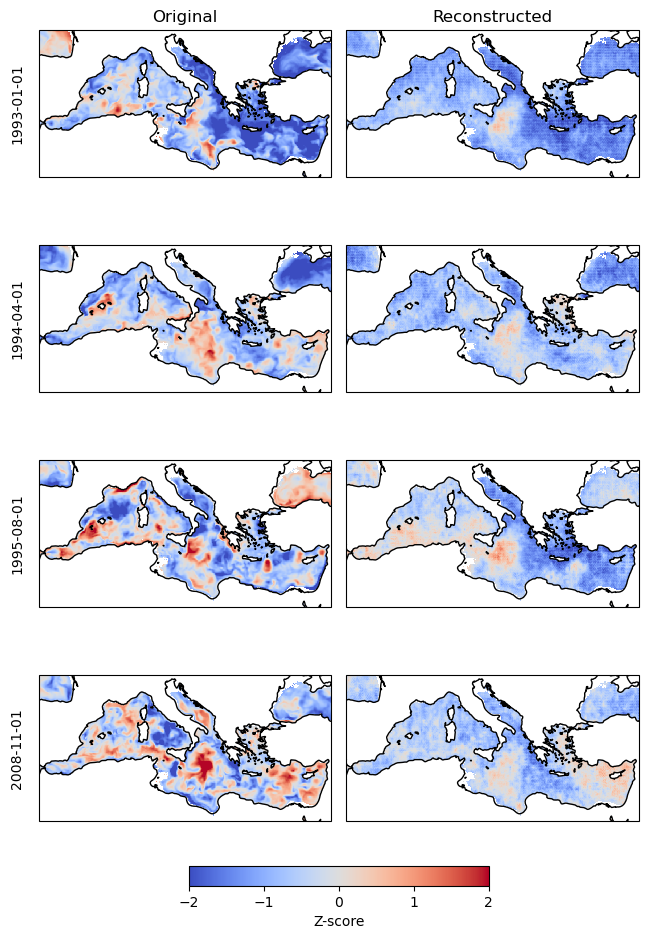

In [61]:
# Schritt 1 – Originale z-Werte stacken
original_z = helper_functions.preprocessing(ds, ["thetao"], [50], "location")

# Schritt 2 – Validitätsmaske vorbereiten
M_mask = M_tensor[0].reshape(-1) > 0  # (C * H * W,)
location_coords = original_z.location.values
time_coords = original_z.time.values

# Schritt 3 – CAE-Rekonstruktion erzeugen
X_recon = reconstruct_in_batches(X, model, device, batch_size=16)

# Schritt 4 – Nur gültige Positionen extrahieren
flat_recon = reconstruction_to_vector_masked_positions(X_recon, M_mask)

# Schritt 5 – Reconstructed z_stack erzeugen
# reconstructed_z = build_z_stack(flat_recon, location_coords, time_coords)
reconstructed_z = helper_functions.reconstructed_to_stack(ds, "thetao", 50, flat_recon)

# Schritt 6 – Vergleich anzeigen
plot_reconstruction_comparison(
    z_stack_original=original_z,
    z_stack_recon=reconstructed_z,
    time_indices=[0, 15, 31, 190],
    cmin=-2,
    cmax=2
)


## Clustering with K-Means

### Clustering the reconstructions

### Latent = 42

In [ ]:
importlib.reload(helper_functions)

In [40]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def reconstruct_in_batches(X, model, device, batch_size=16):
    model.eval()
    recon_list = []

    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():
        for (x_batch,) in loader:
            x_batch = x_batch.to(device)
            x_recon = model(x_batch)
            x_recon = x_recon[:, :, :203, :514]  # falls nötig zuschneiden
            recon_list.append(x_recon.cpu())

    return torch.cat(recon_list, dim=0)  # (time, channels, H, W)


In [31]:
def reconstruction_to_vector_masked_positions(X_recon, valid_flat_mask):
    """
    Extracts only valid positions from each CAE-reconstruction (time, C*H*W).
    
    Args:
        X_recon: torch.Tensor or np.ndarray, shape (T, C, H, W)
        valid_flat_mask: 1D boolean array of shape (C * H * W)

    Returns:
        np.ndarray of shape (T, N_valid_positions)
    """
    if isinstance(X_recon, torch.Tensor):
        X_recon = X_recon.detach().cpu().numpy()
    if isinstance(valid_flat_mask, torch.Tensor):
        valid_flat_mask = valid_flat_mask.detach().cpu().numpy()

    T = X_recon.shape[0]
    flat = X_recon.reshape(T, -1)
    return flat[:, valid_flat_mask]


In [62]:
# Schritt 1: CAE-Rekonstruktion
X_recon_all = reconstruct_in_batches(X, model, device, batch_size=16)

# Schritt 2: Maskenvorbereitung
# M_np kommt z. B. aus deinem preprocessing
M_tensor = torch.tensor(M_np[:, :, :203, :514], dtype=torch.float32)
valid_flat_mask = (M_tensor[0] > 0).reshape(-1).cpu().numpy()

# Schritt 3: Vektorisierung
X_recon_all = reconstruction_to_vector_masked_positions(X_recon_all, valid_flat_mask)


/tmp/ipykernel_6039/1357778119.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(X, dtype=torch.float32))


In [63]:
k=9
labels = helper_functions.apply_kmeans(X_recon_all, k)
labels += 1

In [50]:
print(2)

2


### Depth = 50

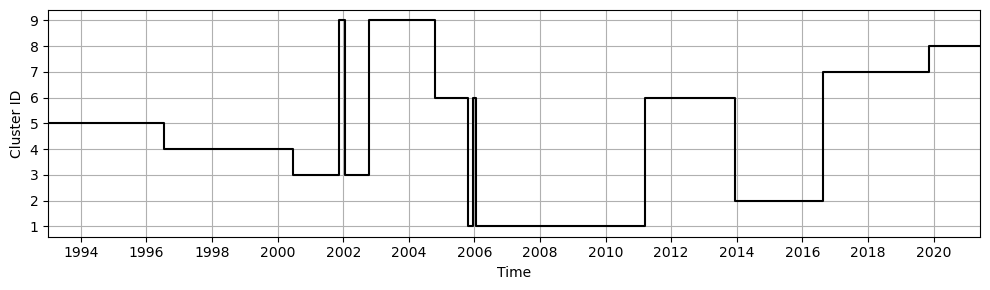

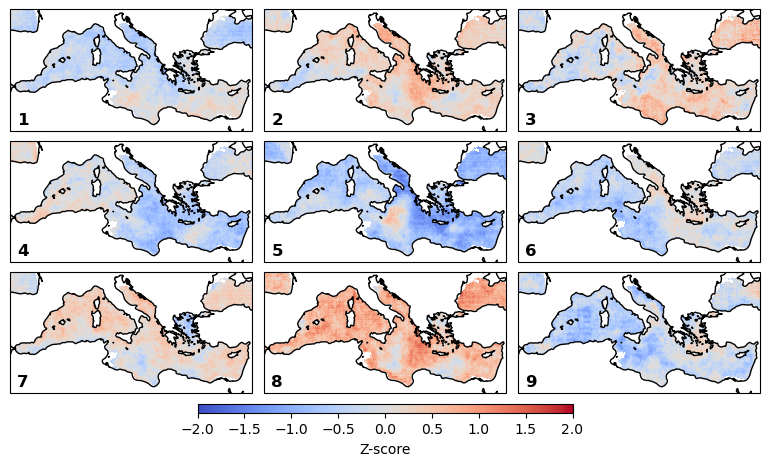

In [64]:
recon_temp_50 = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all)

helper_functions.plot_cluster_timeline(recon_temp_50, labels)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

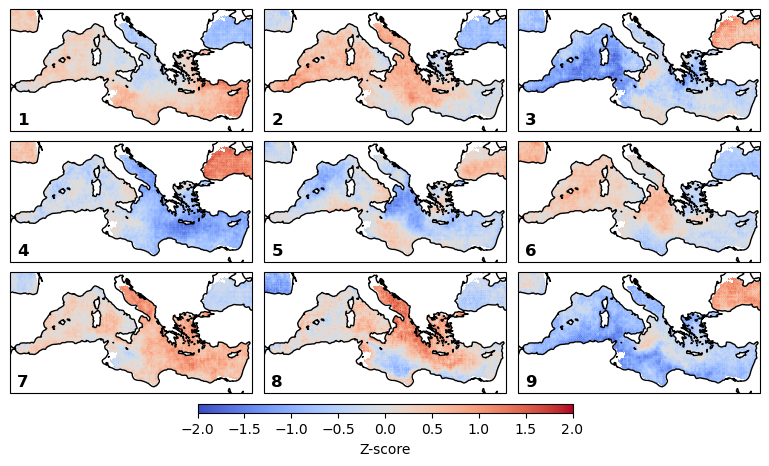

In [65]:
recon_so_50 = helper_functions.reconstructed_to_stack(ds, "so", 50, X_recon_all)
helper_functions.plot_average_cluster(recon_so_50, labels, -2, 2)

### Depth = 300

In [ ]:
recon_temp_300 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_300, labels, -2, 2)

In [ ]:
recon_so_300 = helper_functions.reconstructed_to_stack(ds, "so", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_so_300, labels, -2, 2)

### Depth = 1000

In [ ]:
recon_temp_1000 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

In [ ]:
recon_so_1000 = helper_functions.reconstructed_to_stack(ds, "so", 1000, X_recon_all)
helper_functions.plot_average_cluster(recon_so_1000, labels, -2, 2)

### Latent clustering

In [ ]:
# import numpy as np
# import torch
# from sklearn.cluster import KMeans

# def encode_latents(model, X, batch_size=128):
#     """
#     X: NumPy array (n_samples, n_features)
#     model: trained autoencoder
#     returns: (n_samples, latent_dim)
#     """
#     model.eval()
#     latents = []

#     with torch.no_grad():
#         for i in range(0, len(X), batch_size):
#             batch = X[i:i+batch_size]
#             batch = torch.tensor(batch, dtype=torch.float32).to(device)
#             z = model.encoder(batch)
#             latents.append(z.cpu().numpy())

#     return np.concatenate(latents, axis=0)

# # 1. Latents berechnen
# latents_train = encode_latents(model, X_train)
# latents_test = encode_latents(model, X_test)
# latents_all = np.vstack([latents_train, latents_test])
# # 2. Clustering mit KMeans
# k = 9  # z.B. 5 Cluster
# kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
# labels = kmeans.fit_predict(latents_all)
# labels += 1


# helper_functions.plot_cluster_timeline(z_temp, labels)

# plot_cluster_average_reconstructions(
#     model=model,
#     X=np.vstack([X_train, X_test]),
#     labels=labels,
#     z_stack=z_stack,
#     num_clusters=k,
#     device=device
# )